# AQI

In [1]:
%load_ext autotime

time: 149 µs (started: 2023-03-13 22:40:51 +05:30)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import numpy as np
import pandas as pd
import random
from glob import glob
import os, shutil
import gc
from PIL import Image
from typing import Dict, List, Tuple, Any, Optional
from collections import namedtuple, defaultdict
import copy

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb
from tqdm import tqdm
tqdm.pandas()

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

time: 3.74 s (started: 2023-03-13 22:40:51 +05:30)


## Config

In [3]:
class config:
    seed          = 42
    exp_name      = 'nasscom-taim'
    model_name    = 'pix2pix-rnn-aqi'
    base_model    = 'None'
    train_bs      = 32
    valid_bs      = 2 * train_bs
    image_size    = [224, 224]
    in_channels   = 3
    latent_size   = 128
    hidden_size   = 512
    num_layers    = 2
    bidirectional = 0 # could be 0 or 1
    comment       = f'model-{model_name}|latent_size-{latent_size}|info_channels-{in_channels}|hidden_dim-{hidden_size}|num_layers-{num_layers}|bidirectional-{bidirectional}|dim-{image_size[0]}x{image_size[1]}'
    epochs        = 10
    learning_rate = 3e-4
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
    train_num     = 1

time: 735 µs (started: 2023-03-13 22:40:54 +05:30)


## Utils

In [4]:
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('>>> SEEDED <<<')

set_seed(config.seed)

>>> SEEDED <<<
time: 1.68 ms (started: 2023-03-13 22:40:54 +05:30)


In [5]:
class Conv2DLayer(nn.Module):
    def __init__(
        self,
        in_channels: int, 
        out_channels: int, 
        kernel_size: int, 
        stride: int, 
        padding: int
    ) -> None:
        super(Conv2DLayer, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.bn(self.conv(x)))

time: 512 µs (started: 2023-03-13 22:40:54 +05:30)


In [6]:
class Conv2DTransposeLayer(nn.Module):
    def __init__(
        self,
        in_channels: int, 
        out_channels: int, 
        kernel_size: int, 
        stride: int, 
        padding: int 
    ) -> None:
        super(Conv2DTransposeLayer, self).__init__()
        self.conv = nn.ConvTranspose2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.bn(self.conv(x)))

time: 962 µs (started: 2023-03-13 22:40:54 +05:30)


In [7]:
def get_optimizer(optimizer: optim):
    if config.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer=optimizer, 
            T_max=config.T_max, 
            eta_min=config.min_lr
        )
    elif config.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer=optimizer, 
            T_0=config.T_0, 
            eta_min=config.eta_min
        )
    elif config.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, 
            mode='min',
            factor=0.1, 
            patience=10, 
            threshold=0.0001, 
            min_lr=config.min_lr
        )
    elif config.scheduler == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(
            optimizer=optimizer, 
            gamma=0.85
        )
    elif config.scheduler == None:
        scheduler = None
    else:
        raise NotImplementedError("The Scheduler you have asked has not been implemented")
    return scheduler

time: 737 µs (started: 2023-03-13 22:40:54 +05:30)


## Model

## Encoder

In [8]:
class EncoderLayer(nn.Module):
    def __init__(
            self, 
            in_channels: int,
            latent_size: int, 
            *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.conv1 = Conv2DLayer(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4, padding=1)
        self.conv2 = Conv2DLayer(in_channels=32, out_channels=16, kernel_size=2, stride=4, padding=1)
        self.conv3 = Conv2DLayer(in_channels=16, out_channels=1, kernel_size=2, stride=1, padding=1)
        self.fc    = nn.Linear(in_features=225, out_features=latent_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x

time: 1.21 ms (started: 2023-03-13 22:40:54 +05:30)


### Decoder

In [9]:
class DecoderLayer(nn.Module):
    def __init__(
        self, 
        latent_size: int,
        out_channels: int,
        *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        
        self.conv1 = Conv2DTransposeLayer(in_channels=latent_size, out_channels=128, kernel_size=6, 
                                          stride=3, padding=1)
        self.conv2 = Conv2DTransposeLayer(in_channels=128, out_channels=64, kernel_size=4, stride=4, padding=1)
        self.conv3 = Conv2DTransposeLayer(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv4 = Conv2DTransposeLayer(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.conv5 = Conv2DTransposeLayer(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.conv6 = Conv2DTransposeLayer(in_channels=8, out_channels=3, kernel_size=4, stride=2, padding=1)
#         self.conv7 = Conv2DTransposeLayer(in_channels=4, out_channels=3, kernel_size=4, stride=2, padding=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        return x

time: 1.01 ms (started: 2023-03-13 22:40:54 +05:30)


### Pix2PixRNN

In [32]:
class Pix2PixRNN(nn.Module):
    def __init__(
            self, 
            in_channels: int = 3, 
            latent_size: int = 128,
            hidden_size: int = 512,
            num_layers: int = 2,
            bidirectional: Optional[int] = 1,
            *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.in_channels = in_channels
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.encoder = EncoderLayer(in_channels=in_channels, latent_size=latent_size)
        self.lstm = nn.LSTM(
            input_size=latent_size,
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            bidirectional=True if self.bidirectional == 2 else False
        )
        self.decoder = DecoderLayer(latent_size=self.hidden_size, out_channels=in_channels)

    def _init_hidden_states(self, bs: int) -> Tuple[torch.Tensor]:
        return torch.zeros(self.bidirectional*self.num_layers, bs, self.hidden_size), \
    torch.zeros(self.bidirectional*self.num_layers, bs, self.hidden_size)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        emb = None
        seq_len = x.size(2) # [B, C, D, H, W]
        for ix in range(seq_len):
            if emb is None:
                emb = self.encoder(x[:, ix, :, :, :]).unsqueeze(0)
            else:
                emb = torch.cat([emb, self.encoder(x[:, :, ix, :, :]).unsqueeze(0)], dim=0)
#         emb = self.encoder(x)
        emb = emb.permute(1, 0, 2)
        
        h0, c0 = self._init_hidden_states(64)
        out, (h, c) = self.lstm(emb, (h0, c0))
        
        decoder_inp = torch.cat([h, c])
        decoder_inp = torch.mean(decoder_inp, axis=0).unsqueeze(-1).unsqueeze(-1)
        out = self.decoder(decoder_inp)
        return out


x = torch.randn((64, 3, 8, 224, 224))
model = Pix2PixRNN(in_channels=3, latent_size=128, bidirectional=2)
decoder_inp = model.forward(x)
decoder_inp.shape

RuntimeError: Given groups=1, weight of size [32, 3, 8, 8], expected input[64, 8, 224, 224] to have 3 channels, but got 8 channels instead

time: 1.47 s (started: 2023-03-13 22:41:40 +05:30)


## Training

In [ ]:
def train_one_epoch(
    model: nn.Module, optimizer: optim, scheduler: lr_scheduler, 
    criterion: nn.Module, loader: DataLoader
) -> float:
    model.train()
    running_loss = 0.0
    dataset_size = 0
    
    pbar = tqdm(enumerate(loader), total=len(loader), desc='Train')
    for step, (X, y) in pbar:
        bs = X.shape[0]
        yHat = model.forward(X)
        
        optimizer.zero_grad()
        loss = criterion(yHat, y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        running_loss += (loss.item() * bs)
        dataset_size += bs
        
        epoch_loss = running_loss / dataset_size
        current_lr = optimizer.param_groups[0]['lr']
    
        pbar.set_postfix(loss=f'{epoch_loss:.3f}', lr=f'{current_lr:.5f}')
    
    return epoch_loss


@torch.no_grad()
def validate_one_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module) -> float:
    model.eval()
    running_loss = 0.0
    dataset_size = 0
    
    pbar = tqdm(enumerate(loader), total=len(loader), desc='Evaluation')
    for step, (X, y) in pbar:
        bs = X.shape[0]
        yHat = model.forward(X)
        
        loss = criterion(yHat, y)
        
        running_loss += (bs * loss.item())
        dataset_size += bs
        epoch_loss = running_loss / dataset_size
    
    return epoch_loss

In [ ]:
def run_training(trainloader, validloader):
    wandb.init(
        project='nasscom-taim',
        config={k:v for k, v in vars(config).items() if '__' not in k},
        name=f'iteration-{config.trial_num}',
        group=config.comment
    )
    
    model = Pix2PixRNN(
        in_channels=config.in_channels, 
        latent_size=config.latent_size,
        hidden_size=config.hidden_size, 
        num_layers=config.num_layers
    ).to(config.device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = get_optimizer(optimizer=optimizer)
    
    history = {
        'lr': [],
        'train loss': [],
        'valid loss': []
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = -1
    best_loss = np.infty
    
    wandb.watch(models=[model], log_freq=100)
    
    for epoch in range(config.epochs):
        train_loss = train_one_epoch(model=model, optimizer=optimizer, criterion=criterion, 
                                     scheduler=scheduler, loader=trainloader)
        valid_loss = validate_one_epoch(model=model, loader=validloader, criterion=criterion)
        
        wandb.log({
            'lr': optimizer.param_groups[0]['lr'], 
            'train loss': train_loss, 
            'valid loss': valid_loss
        })
        
        history['lr'].append(optimizer.param_groups[0]['lr'])
        history['train loss'].append(train_loss)
        history['valid loss'].append(valid_loss)
        
        print(f'Validation Loss: {valid_loss:.5f}')
        
        if valid_loss < best_loss:
            print(f'{c_}Validation decreased from {best_loss:.5f} to {valid_loss:.5f}')
            best_loss = valid_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            
            path = f'../../best-models/MODEL-{config.train_num}.bin'
            torch.save(best_model_wts, path)
            wandb.save(path)
            
            print(f"Model Saved{sr_}")
        
    model.load_state_dict(torch.load(f'../../best-models/MODEL-{config.trial_num}.bin'))
    return model, history


## Dataset

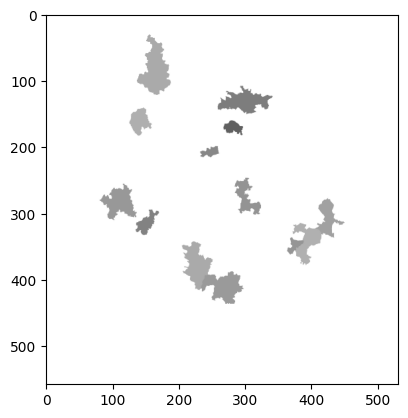

time: 135 ms (started: 2023-03-13 22:41:45 +05:30)


In [36]:
path = '../../../../dataset/aqi/images/2017-01.png'
img = Image.open(path)
img = img.convert('RGB')
plt.imshow(img);

In [37]:
img = np.asarray(img)
img.shape

(558, 532, 3)

time: 1.7 ms (started: 2023-03-13 22:41:45 +05:30)


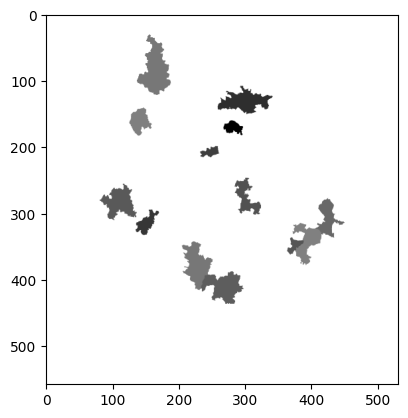

time: 120 ms (started: 2023-03-13 22:41:46 +05:30)


In [38]:
plt.imshow(img[:, :, 0], cmap='gray');

In [39]:
tmp = img
tmp.shape

(558, 532, 3)

time: 1.27 ms (started: 2023-03-13 22:41:46 +05:30)


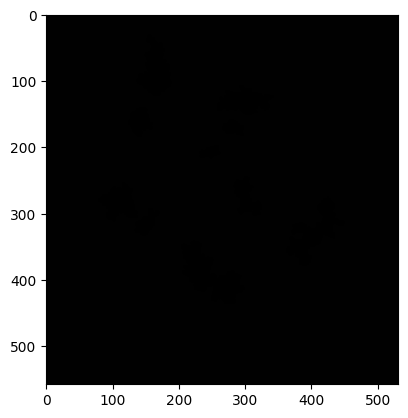

time: 127 ms (started: 2023-03-13 22:41:46 +05:30)


In [40]:
plt.imshow(np.array(tmp == 255).astype(np.uint8))

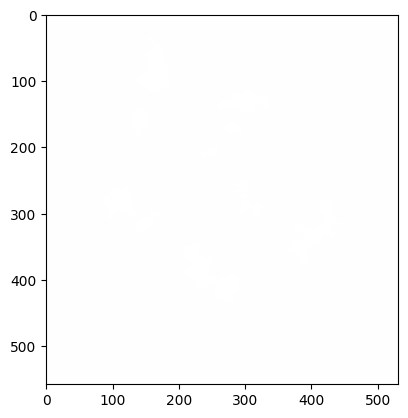

time: 117 ms (started: 2023-03-13 22:41:47 +05:30)


In [41]:
mask = (tmp == 255)
mask = ~mask.astype(np.uint8)
plt.imshow(mask, cmap='gray')

In [42]:
image_paths = sorted(glob('../../../../dataset/aqi/images/*.png'))
df = pd.DataFrame({
    'input': image_paths
})
df.head()

,input
0,../../../../dataset/aqi/images/2017-01.png
1,../../../../dataset/aqi/images/2017-02.png
2,../../../../dataset/aqi/images/2017-03.png
3,../../../../dataset/aqi/images/2017-04.png
4,../../../../dataset/aqi/images/2017-05.png


time: 4.02 ms (started: 2023-03-13 22:41:47 +05:30)


In [43]:
df.shape

(60, 1)

time: 3.2 ms (started: 2023-03-13 22:41:47 +05:30)


In [44]:
df['output'] = np.nan
for ix in range(4, len(df) - 1):
    df.loc[ix - 1, 'output'] = df.loc[ix, 'input']
df.head()

,input,output
0,../../../../dataset/aqi/images/2017-01.png,NaN
1,../../../../dataset/aqi/images/2017-02.png,NaN
2,../../../../dataset/aqi/images/2017-03.png,NaN
3,../../../../dataset/aqi/images/2017-04.png,../../../../dataset/aqi/images/2017-05.png
4,../../../../dataset/aqi/images/2017-05.png,../../../../dataset/aqi/images/2017-06.png


time: 16 ms (started: 2023-03-13 22:41:48 +05:30)


In [45]:
input_paths:  List[List[str]] = []
output_paths: List[str] = []

for ix in range(2, len(df) - 1):
    input_paths.append(df.loc[ix - 2: ix, 'input'].to_list())
    output_paths.append(df.loc[ix, 'output'])

for inp, out in zip(input_paths, output_paths):
    print(inp, out)
    break

['../../../../dataset/aqi/images/2017-01.png', '../../../../dataset/aqi/images/2017-02.png', '../../../../dataset/aqi/images/2017-03.png'] nan
time: 8.86 ms (started: 2023-03-13 22:41:48 +05:30)


In [46]:
class AQIDataset(Dataset):
    def __init__(self, input_paths: List[str], output_paths: List[str]) -> None:
        super(AQIDataset, self).__init__()
        self.input_paths = input_paths
        self.output_paths = output_paths
        self.transforms = A.Compose([
            A.Resize(height=config.image_size[0], width=config.image_size[1]),
            ToTensorV2()
        ], p=1.0)
        
    def __len__(self) -> int:
        return len(self.input_paths)
    
    def __getitem__(self, ix: int) -> Dict[str, torch.Tensor]:
        input_paths = self.input_paths[ix]
        output_path = self.output_paths[ix]
        
        X = None
        masks = None
        y = None
        
        for path in input_paths:
            img = Image.open(path)
            img = img.convert('RGB')
            img = np.asarray(img) # .mean(-1)
            
            transformed = self.transforms(image=img)
            image = transformed['image']
            image = torch.tensor(image).unsqueeze(0)
            
            if X is None:
                X = image
            else:
                X = torch.cat([X, image], dim=0)
            
        img = Image.open(path)
        img = img.convert('RGB')
        img = np.asarray(img) # .mean(-1)
        mask = (img == 255)
        mask = ~mask.astype(np.uint8)
        
        transformed = self.transforms(image=img, mask=mask)
        image = transformed['image']
        mask  = transformed['mask']
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        
        return {
            'X': X, 
            'mask': mask, 
            'y': image
        }

time: 2.04 ms (started: 2023-03-13 22:41:48 +05:30)


In [47]:
dataset = AQIDataset(input_paths, output_paths)

time: 408 µs (started: 2023-03-13 22:41:49 +05:30)


In [48]:
batch = dataset[0]
{k: v.shape for k, v in batch.items()}

{'X': torch.Size([3, 3, 224, 224]),
 'mask': torch.Size([224, 224, 3]),
 'y': torch.Size([3, 224, 224])}

time: 56.5 ms (started: 2023-03-13 22:41:49 +05:30)


In [49]:
len(dataset)

57

time: 3.14 ms (started: 2023-03-13 22:41:50 +05:30)


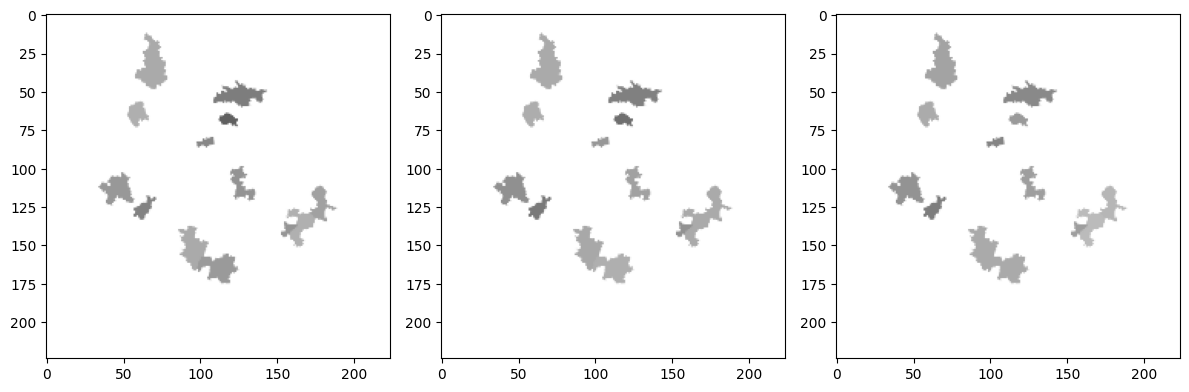

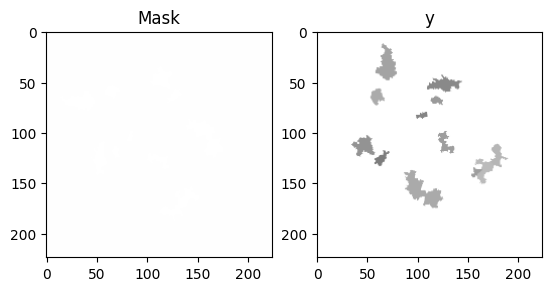

time: 400 ms (started: 2023-03-13 22:41:50 +05:30)


In [50]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
for ix, ax in enumerate(axs.flatten()):
    ax.imshow(batch['X'][ix, ...].permute(1, 2, 0), cmap='gray')
plt.tight_layout()
plt.show()

plt.subplot(121)
plt.imshow(batch['mask'].permute(1, 0, 2).numpy().astype(np.uint8), cmap='gray')
plt.title('Mask')

plt.subplot(122)
plt.imshow(batch['y'].permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
plt.title('y')

plt.show()

In [51]:
model = Pix2PixRNN(in_channels=1)
model

Pix2PixRNN(
  (encoder): EncoderLayer(
    (conv1): Conv2DLayer(
      (conv): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Conv2DLayer(
      (conv): Conv2d(32, 16, kernel_size=(2, 2), stride=(4, 4), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): Conv2DLayer(
      (conv): Conv2d(16, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc): Linear(in_features=225, out_features=128, bias=True)
  )
  (lstm): LSTM(128, 512, num_layers=2, batch_first=True)
  (decoder): DecoderLayer(
    (conv1): Conv2DTransposeLayer(
      (conv): ConvTranspose2d(512, 128, kernel_size=(6, 6), stride=(3, 3), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

time: 35.9 ms (started: 2023-03-13 22:41:50 +05:30)


In [52]:
loader = DataLoader(dataset, batch_size=4)

time: 1.06 ms (started: 2023-03-13 22:41:52 +05:30)


In [53]:
batch = next(iter(loader))
{k: v.shape for k, v in batch.items()}

{'X': torch.Size([4, 3, 3, 224, 224]),
 'mask': torch.Size([4, 224, 224, 3]),
 'y': torch.Size([4, 3, 224, 224])}

time: 159 ms (started: 2023-03-13 22:41:52 +05:30)


In [54]:
y = model.forward(batch['X'])

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

time: 74.1 ms (started: 2023-03-13 22:41:53 +05:30)
